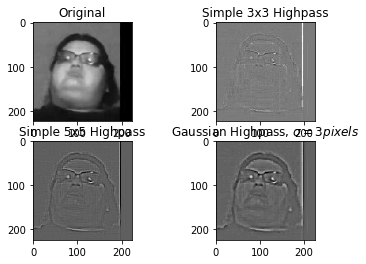

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from PIL import Image

def plot(data, title):
    plot.i += 1
    plt.subplot(2,2,plot.i)
    plt.imshow(data)
    plt.gray()
    plt.title(title)
plot.i = 0

# Load the data...
im = Image.open('/home/kb/hdd/extracted_faces_224_blaze_v3_15fpv/dfdc_train_part_1/FAKE_aassnaulhq_2.jpg')
data = np.array(im, dtype=float)[:,:,0]
plot(data, 'Original')

# A very simple and very narrow highpass filter
kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
highpass_3x3 = ndimage.convolve(data, kernel)
plot(highpass_3x3, 'Simple 3x3 Highpass')

# A slightly "wider", but sill very simple highpass filter 
kernel = np.array([[-1, -1, -1, -1, -1],
                   [-1,  1,  2,  1, -1],
                   [-1,  2,  4,  2, -1],
                   [-1,  1,  2,  1, -1],
                   [-1, -1, -1, -1, -1]])
highpass_5x5 = ndimage.convolve(data, kernel)
plot(highpass_5x5, 'Simple 5x5 Highpass')

# Another way of making a highpass filter is to simply subtract a lowpass
# filtered image from the original. Here, we'll use a simple gaussian filter
# to "blur" (i.e. a lowpass filter) the original.
lowpass = ndimage.gaussian_filter(data, 3)
gauss_highpass = data - lowpass
plot(gauss_highpass, r'Gaussian Highpass, $\sigma = 3 pixels$')

plt.show()

In [2]:
import torch
import math
from torch import nn

In [3]:
# Set these to whatever you want for your gaussian filter
kernel_size = 8
sigma = 3
channels = 3

def create_filter(kernel_size = 7, sigma = 3, channels = 3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_cord = torch.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1)

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False
                                , padding=(int(kernel_size/2),int(kernel_size/2))
                               )

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    return gaussian_filter


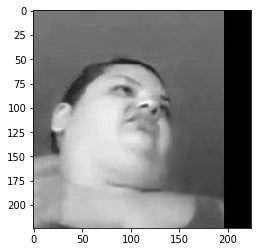

In [5]:
# im = Image.open('/home/kb/hdd/extracted_faces_224_blaze_v3_15fpv/dfdc_train_part_1/FAKE_aassnaulhq_2.jpg')
im = Image.open('/home/kb/hdd/extracted_faces_224_blaze_v3_15fpv/dfdc_train_part_1/REAL_zwswwwrefl_9.jpg')
# im = Image.open('/home/kb/hdd/extracted_faces_224_blaze_v3_15fpv/dfdc_train_part_36/FAKE_mwpkteojuk_9.jpg')

data = np.array(im, dtype=np.float32)
plt.figure()
plt.imshow(data[:,:,0])

In [9]:
img =torch.tensor(data).float().cuda()

img = img.permute(2, 0, 1) 

gaussian_filter = create_filter(kernel_size=3, sigma=3, channels=3).cuda()

x = gaussian_filter(img.unsqueeze(0))

img_hp = img - x[0]

In [10]:
img.shape

torch.Size([3, 224, 224])

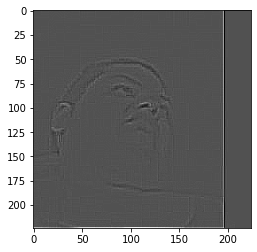

In [11]:
plt.figure()
plt.imshow(np.array(img_hp.permute(1,2,0).cpu(), 
                    dtype=np.float32
                   )[:,:,0]
          )

plt.show()

In [15]:
x.shape

torch.Size([1, 3, 224, 224])

In [24]:
torch.mean(x, dim=(2,3)).unsqueeze(2).unsqueeze(3).shape

torch.Size([1, 3, 1, 1])

In [25]:
(x - torch.mean(x, dim=(2,3)).unsqueeze(2).unsqueeze(3) ).shape

torch.Size([1, 3, 224, 224])